# Курсовий проект. Тема "Перегляд реклами"
* Метою цього проєкту є аналіз ефективності показу онлайн-реклами. 
* Основнa задача: Побудова моделі для прогнозування кількості переглядів залежно від часу, типу реклами та інших параметрів.

**Завдання**
1. **EDA (Exploratory Data Analysis)**:
   - Проаналізуйте дані на наявність трендів, сезонності та аномалій.   
   - Візуалізуйте дані (часові графіки, гістограми, теплові карти тощо).  

2. **Попередня обробка**:
   - Врахуйте аномалії у даних: визначте, чи потрібно їх видалити, згладити або моделювати окремо.

3. **Прогнозування**:
   - Використовуйте оброблені дані для створення моделі прогнозування на 7 днів наперед.  
   - Виберіть модель, яка враховує тренди та сезонність (наприклад, ARIMA, Prophet або LSTM).  

4. **Оцінка результатів**:
   - Перевірте якість прогнозу, використовуючи метрики (наприклад, RMSE, MAE).  
   - Інтерпретуйте отриманий прогноз і перевірте, як модель справляється з аномаліями.
  
Дані: набір містить інформацію про кількість перегрлядів реклами під час комп'ютерної гри. Дані агреговані погодинно.

# Виконання

#### Завантажуємо дані та спостерігаємо

In [127]:
import pandas as pd
data = pd.read_csv('data/ads.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)
data.head()


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


<Axes: xlabel='Time'>

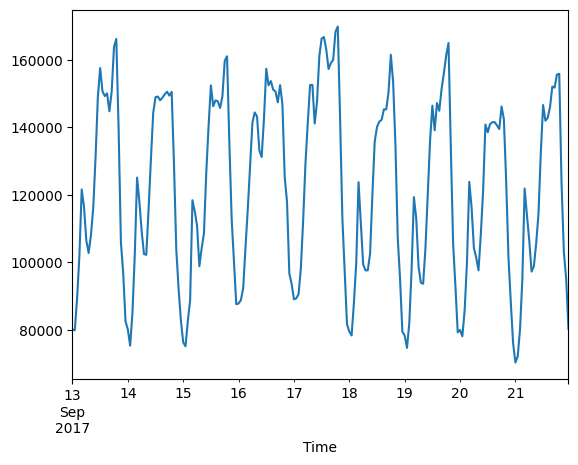

In [128]:
data['Ads'].plot()

#### Аналізуємо дані
**Виявлені деталі**
* Дані рівномірні та без пропусків - передобробка не потрібна.
* Явний тренд відсутній - можна його не виділяти.
* Існує явно виражена сезонність, два рівня, більша - добова, та менша - приблизно 3-4 аплітуди на добу - необхідно їх виділити.

**Рішення**
* На всяк випадок зробимо ADF тест щоб впевнитися що ряд стаціонарний.
* Так як вже існує хоча б одна явно виражена компонента - треба виділити компоненти тренду, сезонності і шуму всі разом і проаналізувати їх окремо.

#### Перевіряємо ряд на стаціонарність

In [129]:
from statsmodels.tsa.stattools import adfuller
stability = adfuller(data.dropna())

print(f"ADF Statistic: {stability[0]}")
print(f"p-value: {stability[1]}")
print(f"Timeseries is", "STABLE" if stability[1] < 0.05 else "UNSTABLE")

ADF Statistic: -7.089633890638511
p-value: 4.4448036886224977e-10
Timeseries is STABLE


**Виявлені деталі**
* Ряд стаціонарний - диференціювати не потрібно

#### Виділяємо сезонність

<Axes: xlabel='Time'>

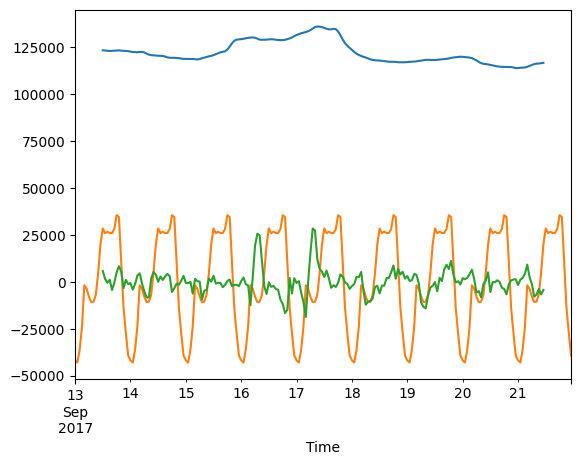

In [130]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_result = seasonal_decompose(data, period=24)

decomposition_trend = decomposition_result.trend
decomposition_seasonal = decomposition_result.seasonal
decomposition_residuals = decomposition_result.resid

decomposition_trend.plot()
decomposition_seasonal.plot()
decomposition_residuals.plot()

In [131]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

correlation = np.corrcoef(decomposition_trend.dropna(), decomposition_residuals.dropna())[0, 1]
print(f"Кореляція між трендом і шумами: {correlation:.4f}")

Кореляція між трендом і шумами: 0.1536


Mean: -54.6897, Std: 6694.6272
Data is depended (is not noise): TRUE


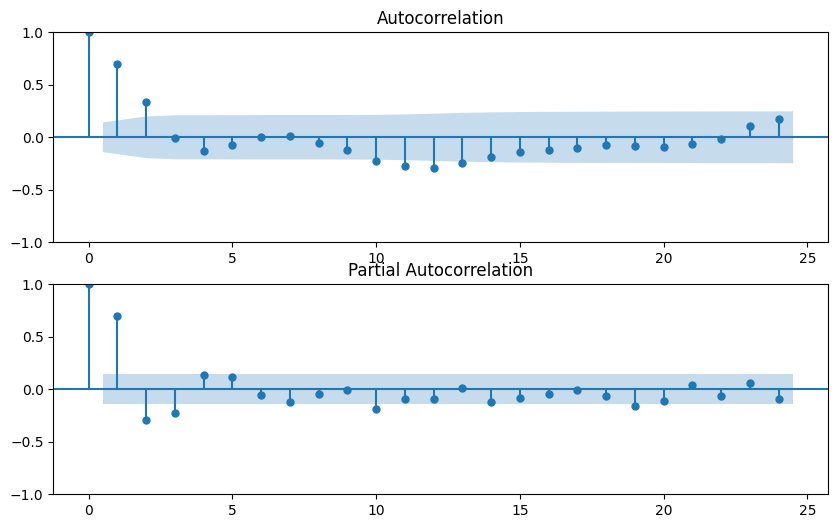

In [132]:
mean_residuals = decomposition_residuals.dropna().mean()
std_residuals = decomposition_residuals.dropna().std()
print(f"Mean: {mean_residuals:.4f}, Std: {std_residuals:.4f}")

from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(decomposition_residuals.dropna(), lags=[24], return_df=True)
print("Data is depended (is not noise):", "TRUE" if lb_test["lb_pvalue"].values[0] < 0.05 else "FALSE")

fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(decomposition_residuals.dropna(), lags=24, ax=axes[0])
plot_pacf(decomposition_residuals.dropna(), lags=24, ax=axes[1])
plt.show()

**Виявлені деталі**
* Сезонність дуже чітка і стабільна - можна застосувати метод Furier Transformation який чітко виділить гармоніки.
* Тренд - вже ж таки має неочікуванні скачки, є підозра що вони корелюють зі скачками на шумах, але кореляція це не підтвердила, тому розглядаємо їх окремо.
* Шуми не схожі на реальний шум - Ljung-Box тест це підтверджує (є залежність від попередніх значень) та mean != 0 що значить що є постійне зміщення - треба буде використовувати ARIMA для прогнозування. Визначемо параметри p, d, q. Ряд стаціонарний, тому d = 1 - не робимо диференціяцію. Автокореляція показує що лаг = 2 найбільше впливають на поточне значения, тому q = 2. Часткова автокореляція показує, що після перших двух значень різко падає кореляція, а тому 2й лаг це є той лаг з якого можно визначати авторегресію.
* Тренд може бути або просто аномалією або циклічним трендом який не видно в масштабі наданих даних (більше місяця). За допомогою Furier Transformation спробуємо отримати якусь одну вагому частоту - якщо буде - то це все ж таки сезонність, якщо ні - аномалія.